# Loading data and baseline

This notebook loads the data and calculates the baseline for the accuracy.
It also plots the ROC figure of the Random Forest classifier applied to the dataset.
You can choose between two datasets - one from the **Myocardial infarction complications**
and the other from the **PIMA Indians diabetes database**.
Per default the second dataset is used, as it gives better results. 
But the first is still available for you to try it out.

## First exercices

- Change data model to `get_diabetes` and compare the accuracy of the model.
Don't forget to change it back afterwards.
- Look at the call to `plot_rfc_auroc`: why does it take the second element of the array?
- Once you're done, change the `verbose_load` to `False` and save the notebook.

## Further exercices

- Regarding the ROC plot, can you tell which decision threshold is necessary to
get a specific TPR/FPR ratio?

## Advanced exercices - not supported

- Add another dataset where you need a neural network to train.

In [2]:
# All needed imports

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy import stats
from tqdm import tqdm as tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss, roc_curve, roc_auc_score, auc, RocCurveDisplay

verbose_load = True

In [12]:
# Define two data models for testing

def get_heart_failure():
    # Dataset: https://figshare.le.ac.uk/articles/dataset/Myocardial_infarction_complications_Database/12045261/3
    # Myocardial infarction complications
    if verbose_load:
        print("Loading myocardial infarction dataset")
        
    df = pd.read_csv("https://figshare.le.ac.uk/ndownloader/files/23581310")
    complications = df.columns[-12:]
    target_complication = "ZSN"  # Chronic heart failure
    freq_na_cols = df.columns[df.isna().mean(axis=0) > 0.1]
    df = df.drop(columns=freq_na_cols).dropna()

    X = df.drop(columns=complications)
    y = df[target_complication]
    return X, y


def get_diabetes():
    # Dataset: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
    # As you need to sign in, this uses a local copy
    if verbose_load:
        print("Loading diabetes dataset")
        
    df = pd.read_csv('datasets/diabetes.csv')

    df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
    df['Glucose'].fillna(df['Glucose'].mean(), inplace=True)
    df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace=True)
    df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace=True)
    df['Insulin'].fillna(df['Insulin'].mean(), inplace=True)
    df['BMI'].fillna(df['BMI'].mean(), inplace=True)
    
    target = "Outcome"
    X = df.drop(columns=target)
    y = df[target]

    return X, y


#X, y = get_heart_failure()
X, y = get_diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Loading diabetes dataset


### Fit a simple RandomForestClassifier

In [13]:
def train_model(X_train, y_train, seed=42):
    rfc = RandomForestClassifier(
        n_estimators=75,
        min_samples_split=2,
        max_depth=8,
        random_state=seed,
    )
    rfc.fit(X_train, y_train)
    return rfc
    
target_model = train_model(X_train, y_train)

if verbose_load:
    # The classifier's accuracy vs. random baseline. We are doing a bit better than the baseline.
    print(f"Baseline: {max(y_test.mean(), 1 - y_test.mean()):0.2f}")
    print(f"Our test-score: {target_model.score(X_test, y_test):0.2f}" )

Baseline: 0.64
Our test-score: 0.75


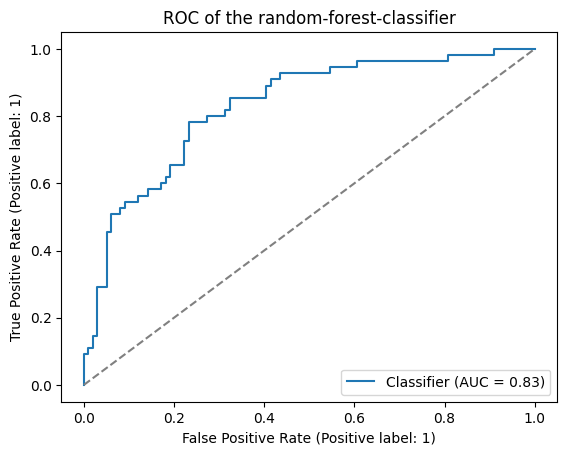

In [14]:
def plot_rfc_auroc(y_test, y_pred_proba, title="ROC"):
    # Display an AUROC figure for the model
    RocCurveDisplay.from_predictions(y_test, y_pred_proba)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(title)
    
if verbose_load:
    plot_rfc_auroc(y_test, target_model.predict_proba(X=X_test)[:,1], "ROC of the random-forest-classifier")

In [ ]:
# Common methods used by other notebooks to calculate the logit of the outputs.
# This converts an array of [0..1] to an array of [-inf..inf].

def logit_scale(y_true, y_pred, eps=1e-16):
    """
    Logit scaling from https://arxiv.org/abs/2112.03570
    """
    if isinstance(y_true, np.integer):
        y_true = [y_true] * len(y_pred)
        
    result = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for i in range(len(y_true)):
        y = y_true[i]
        pred = y_pred[i, y]
        result.append(
            np.log(np.clip(pred / np.clip(1 - pred, eps, np.inf), eps, np.inf))
        )
    return np.array(result)


def logits(target_model, X_true, y_true):
    y_pred = target_model.predict_proba(X_true)
    return logit_scale(y_true, y_pred)